# **Sentiment Analysis using LSTM**
We will implement a neural network that will perform sentiment analysis on movie reviews and classify them as positive or negative.

## **Import the Libraries**

Run the cell below to import all the necessary libraries for building the sentiment analysis model.

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\khand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\khand\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Loading the Dataset**

The below cell contains a function `getdata`, which takes as argument the path to `reviews.csv`, loads the CSV file into a Pandas DataFrame and finally returns the DataFrame.
Run the cell to load the dataset.

In [41]:
def getdata(path):
  df = pd.read_csv(path)
  return df

path = 'reviews.csv'

df = getdata(path)
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## **Splitting the Dataset into Training and Testing Data**
The below cell that splits the loaded data into training and testing sets. The recommended train:test ratio is 80:20, but feel free to change this later and see how it affects the accuracy of the model. Note that the cell should store the training and testing reviews in `x_train` and `x_test` respectively, and their corresponding sentiments in `y_train` and `y_test` respectively.

In [42]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

x_train = np.reshape(train_df.iloc[:,[0]].to_numpy(),40000)
x_test =  np.reshape(test_df.iloc[:,[0]].to_numpy(),10000)
y_train = np.reshape(train_df.iloc[:,[1]].to_numpy(),40000)
y_test = np.reshape(test_df.iloc[:,[1]].to_numpy(),10000)

print(x_train.shape)
print(x_test.shape)

(40000,)
(10000,)


Before we proceed, let's make sure we have a well distributed training dataset by checking the number of positive and negative reviews it contains.

If your values deviate too much from the optimal 50-50 ratio, it is recommended that you modify the above cell to shuffle the dataset differently.

In [43]:
count_positive = 0
count_negative = 0

for i in y_train:
  if i == "positive":
    count_positive += 1
  else:
    count_negative += 1

print("Positive reviews:", count_positive/(count_positive + count_negative)*100, "%")
print("Negative reviews:", count_negative/(count_positive + count_negative)*100, "%")

Positive reviews: 49.902499999999996 %
Negative reviews: 50.0975 %


## **Preprocessing**
Preprocessing a very important step in NLP.
The function take as input a set of reviews `x_train` or `x_test`, and return a list of preprocessed reviews.

1.   Case the corpus to lower case
2.   Remove punctuation
3.   Lemmatize
4.   Remove stop words

Feel free to refer to last week's assignment for guidance.

*Note that as the dataset is much larger this time, the cell may take a while to run.*

In [44]:
#The list of stopwords has been coverted into a set, making it faster to check if a given word is in it
stop_words = set(stopwords.words('english'))

# Using the below tokenizer helps us get rid of punctuation,
tokenizer = RegexpTokenizer(r'\w+')

# And the lemmatizer to convert words to simpler forms
lemmatizer = WordNetLemmatizer()

def preprocess(x_set):
    result = []
    
    for i in x_set:
      out = str(i).lower()
      out = tokenizer.tokenize(out)
      out = [j for j in out if j not in stop_words]
      out = [lemmatizer.lemmatize(j) for j in out]
      
      result.append(out)
    return result

#Testing the function
test_preprocess = preprocess(["This is an test.",'The notebook runs on the jupiter.','The jupiter, however, is very much on the space,'])
print(test_preprocess)
#assert test_preprocess == [['test'], ['notebook', 'run', 'jupiter'], ['jupiter', 'however', 'much', 'space']]

x_train_preprocessed = preprocess(x_train)
x_test_preprocessed = preprocess(x_test)

[['test'], ['notebook', 'run', 'jupiter'], ['jupiter', 'however', 'much', 'space']]


## **Building the Vocabulary**
The below function which takes as argument the preprocessed **training set**, returns a dictionary mapping each unique word to a unique ID. We are giving the first word an ID of `1`.

In [45]:
def create_vocabulary(x_train_preprocessed):
  '''Creates a dictionary with all unique words in corpus with id'''
  vocabulary = {}
  id = 1
  for s in x_train_preprocessed:
    for j in s:
      if j not in vocabulary:
        vocabulary[j]=id
        id+=1
  return vocabulary

vocabulary = create_vocabulary(x_train_preprocessed)
print(len(vocabulary))

84036


## **Converting to Numerical Form**
Since we need to convert our words into numerical input for the neural network to be able to process it, let's replace the words in our reviews with their corresponding IDs from the vocabulary (not their one-hot embeddings, just their IDs).


In [46]:
def convert_to_numerical(x_set):
  converted = []
  count = 0
  unk = 'unk'
  vocabulary[unk] = len(vocabulary)
  for x in x_set:
    converted.append([])
    for word in x:
      if word in vocabulary:
        converted[count].append(vocabulary[word])
      else:
        converted[count].append(vocabulary[unk])
    count+=1

  return converted

#Testing your function
vocab_list = list(vocabulary.keys())
print(convert_to_numerical([[vocab_list[47],vocab_list[186],vocab_list[4005]]]))
# assert convert_to_numerical([[vocab_list[47],vocab_list[186],vocab_list[4005]]]) == [[48, 187, 4006]]

[[48, 187, 4006]]


In [47]:
x_train_numerical = convert_to_numerical(x_train_preprocessed)
x_test_numerical = convert_to_numerical(x_test_preprocessed)

print(len(x_train_numerical))

40000


Notice that our sentiment labels (`y_train` and `y_test`) currently contain the words `positive` and `negative`. Let's convert them to `1` and `0` respectively.

In [48]:
def convert_labels(y_set):
  converted=[]
  for i in y_set:
    if(i == 'positive'):
      converted.append(1)
    else:
      converted.append(0)
  return converted

assert convert_labels(['positive','negative','positive','positive','negative']) == [1,0,1,1,0]

y_train_numerical = convert_labels(y_train)
y_test_numerical = convert_labels(y_test)

print(len(y_train_numerical))

40000


## **Normalizing the Reviews' lengths**
Since our reviews have variable lengths, we will employ a technique called **padding**.to normalize them.

Run the below cell to analyze the present lengths of our reviews.

In [49]:
lengths = [len(i) for i in x_train_preprocessed]
lengths_sum = sum(lengths)
num_lengths = len(lengths)
avg_length = lengths_sum/num_lengths
max_length = max(lengths)

print("Average length of reviews: ", avg_length)
print("Length of the longest review: ", max_length)

Average length of reviews:  123.540625
Length of the longest review:  1455


Padding all the reviews to the maximum length would preserve all our data, but at the same time it would be highly inefficient. Instead, let's settle on an intermediate value of 150 and pad all shorter reviews to 150. As for the longer ones, our model can probably perform sentiment analysis without the *entire* review, so we'll truncate them to 150 words.

For this purpose, we shall use a ghost ID of `0` to represent the padding token. This is why we did not give this ID to the first word.

Run the below cell to normalize the lengths as mentioned.

In [50]:
def normalize(x_set, max_length):
    temp = np.zeros((len(x_set), max_length),dtype=int)
    for i, sentence in enumerate(x_set):
        if len(sentence) != 0:
            temp[i, -len(sentence):] = np.array(sentence)[:max_length]
    return temp

max_length = 150

x_train_normalized = normalize(x_train_numerical, max_length)
x_test_normalized = normalize(x_test_numerical, max_length)

## **Converting the Data to Tensors**
Now that we are done processing all the reviews, it's time to start building our sentiment analysis model. But first, we'll need to convert our training and testing data into a suitable form.

This can be done using the `TensorDataset` class of PyTorch, which creates a dataset containing tensors for input features and labels.

Since this class takes only NumPy ndarrays as parameters, we'll need to convert `y_train_numerical` and `y_test_numerical` into ndarrays.

In [51]:
final_train_data = TensorDataset(torch.from_numpy(x_train_normalized), torch.tensor(y_train_numerical))
final_test_data = TensorDataset(torch.from_numpy(x_test_normalized), torch.tensor(y_test_numerical))

## **Loading the Data in Batches**
Since our dataset is quite large, loading it all at once won't be feasible. A much more efficient way of loading the dataset is to do it in **batches**. This can be done using PyTorch's DataLoader constructor.

The below cell creates `train_batch_loader` and `test_batch_loader`, using the variable `batch_size`.

<details>
  <summary>Note</summary>
The shuffle = True parameter is important, omitting it would defeat the purpose of batching!</details>

In [52]:
batch_size = 64

train_batch_loader = DataLoader(final_train_data, shuffle=True, batch_size=batch_size)
test_batch_loader = DataLoader(final_test_data, shuffle=True, batch_size=batch_size)

Observe that the size of any set of input features is $[\textrm{number of batches}, \textrm{maximum (normalized) length of review}]$.

In [53]:
sample_batch = train_batch_loader
for x, y in sample_batch:
  print("Input size:", x.size())
  print("Input feature: \n", x)
  print("Label: \n", y)
  break


Input size: torch.Size([64, 150])
Input feature: 
 tensor([[ 1281,  2361,   289,  ...,  2873, 13367, 17605],
        [    0,     0,     0,  ...,  1912,  3789, 32692],
        [28301,  1691,  5459,  ...,    19,   119, 28900],
        ...,
        [    0,     0,     0,  ..., 22384,   411,  8770],
        [ 2111,  4224,   238,  ...,    85,    77,   585],
        [    0,     0,     0,  ...,    60,    61,  2548]], dtype=torch.int32)
Label: 
 tensor([1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])


## **Building the Model**
We are ready to build the RNN model. We will be using **Python classes** to define the model. The class will inherit from `torch.nn.Module`, which is PyTorch's base class for all neural network modules.

The model will have 5 parts:
- An **Embedding** layer that converts the IDs of all the words in the vocabulary, and converts them to embedding vectors of a defined size  
Note that this is basically doing the job of the emdedding model from last time
- The **LSTM layer(s)** that will sequentially run through the data.  
PyTorch allows you to define multiple continuous LSTM layers with a simpler syntax than having to individually define each one
- The **Dropout** layer. This makes sure our model doesn't overfit the training data. With a predefined probability, it excludes certain nodes from the architecture in each training run.
- The **Linear** layer. This takes the predicted tokens and converts them into a single prediction on whether or not the sentiment is positive or negative.
- Of course, the part of making the predicition a probability is done by the **Sigmoid** layer

In [54]:
class RNN_SA(nn.Module):
    def __init__(self, num_layers, hidden_layer_size, embedding_layer_size, output_layer_size, vocabulary_size, dropout_probability=0.5):
        super(RNN_SA,self).__init__()

        self.output_layer_size = output_layer_size
        self.hidden_dim = hidden_layer_size
        self.num_layers = num_layers
        self.vocabulary_size = vocabulary_size

        self.embedding = nn.Embedding(vocabulary_size,embedding_layer_size)
        
        self.lstm = nn.LSTM(embedding_layer_size,hidden_layer_size,num_layers,batch_first = True)
        
        self.dropout_layer = nn.Dropout(dropout_probability,inplace = False)
        
        self.linear_layer = nn.Linear(hidden_layer_size,output_layer_size,bias = True)
        self.sigmoid_layer = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out,_ = self.lstm(embeds)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout_layer(lstm_out)
        out = self.linear_layer(out)
        sig_out = self.sigmoid_layer(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        return sig_out

Creating a model using the class you just defined.

Note that vocabulary_size = len(vocabulary) + 1
The extra 1 is because of the ghost ID 0 we added for padding

In [55]:
num_layers = 2
vocabulary_size = len(vocabulary) + 1
embedding_layer_size = 64
output_layer_size = 1
hidden_layer_size = 256


model = RNN_SA(num_layers, hidden_layer_size, embedding_layer_size, output_layer_size, vocabulary_size, dropout_probability=0.3)
model.to(device)

print(model)

RNN_SA(
  (embedding): Embedding(84038, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (linear_layer): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid_layer): Sigmoid()
)


Expected:
```console
RNN_SA(
  (embedding): Embedding(VOCAB_SIZE, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (linear_layer): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid_layer): Sigmoid()
)
```

## **Training the Model**
Now that we have our model, let's begin training it on our training data. The hyperparameters have been defined. You might notice that the number of epochs is quite low; this is because each epoch takes a pretty long time to run and a model trained with even 5 epochs would take over an hour to finish training.

Since our model is a binary classifier trained to predict 0 and 1, we can use Binary Cross Entropy loss to measure the loss.


In [56]:
learning_rate = 1e-3
num_epochs = 5

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

def accuracy(prediction, label):
    prediction = torch.round(prediction.squeeze())
    return torch.sum(prediction == label.squeeze()).item()

min_loss_attained = np.Inf    # this variable will contain the minimum value of the loss function attained in any of the epochs. It is used to discard the results of further epochs if their losses are more than min_loss_attained.

epoch_train_loss,epoch_test_loss = [],[]
epoch_train_acc,epoch_test_acc = [],[]    # These lists will hold the average loss and accuracy values of each epoch



for epoch in range(num_epochs):
  train_losses = 0.0
  train_accuracy = 0.0

  progress_bar = tqdm(total=len(train_batch_loader), desc='Training', leave = True)

  model.train()

  for inputs, labels in train_batch_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    output = model(inputs)

    labels = labels.float()
    loss = criterion(output,labels)
    loss.backward()
    optimizer.step()

    # Calculating loss and accuracy; we will store the cumulative values and finally use them to compute the average loss and accuracy of the epoch
    train_losses += loss.item()
    acc = accuracy(output,labels)
    train_accuracy += acc

    nn.utils.clip_grad_norm_(model.parameters(), 5) # This line helps avoid the exploding gradient problem

    optimizer.step()

    progress_bar.update(1)

  progress_bar.close()

  # After the training run of each epoch, we will evaluate the performance of our model

  test_losses = 0.0  # Again, this will store cumulative loss
  test_accuracy = 0.0   # and this will store cumulative test accuracy

  model.eval()

  for inputs, labels in test_batch_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    # Compute the loss
    output = model(inputs)
    labels = labels.float()
    test_loss = criterion(output,labels)

    test_losses += test_loss.item()

    acc = accuracy(output,labels)
    test_accuracy += acc


  epoch_train_accuracy = train_accuracy/len(train_batch_loader.dataset)
  epoch_test_accuracy = test_accuracy/len(test_batch_loader.dataset)


  avg_train_loss = np.mean(train_losses)
  avg_test_loss = np.mean(test_losses)

  epoch_train_loss.append(avg_train_loss)
  epoch_test_loss.append(avg_test_loss)
  epoch_test_acc.append(epoch_test_accuracy)
  epoch_train_acc.append(epoch_train_accuracy)

  print(f'Epoch {epoch+1}')
  print(f'train_loss : {avg_train_loss} test_loss : {avg_test_loss}')
  print(f'train_accuracy : {epoch_train_accuracy*100} test_accuracy : {epoch_test_accuracy*100}')
  if avg_test_loss < min_loss_attained:
    torch.save(model.state_dict(), 'state_dict.pt')
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(min_loss_attained, avg_test_loss))
    min_loss_attained = avg_test_loss
  print(70*'=')


Training: 100%|██████████| 625/625 [00:11<00:00, 53.97it/s]


Epoch 1
train_loss : 382.91785845160484 test_loss : 71.371990442276
train_accuracy : 64.4675 test_accuracy : 79.16
Validation loss decreased (inf --> 71.371990).  Saving model ...


Training: 100%|██████████| 625/625 [00:10<00:00, 58.93it/s]


Epoch 2
train_loss : 217.5136263370514 test_loss : 55.535794138908386
train_accuracy : 85.16749999999999 test_accuracy : 85.15
Validation loss decreased (71.371990 --> 55.535794).  Saving model ...


Training: 100%|██████████| 625/625 [00:10<00:00, 60.51it/s]


Epoch 3
train_loss : 150.70520251989365 test_loss : 51.829932391643524
train_accuracy : 90.39 test_accuracy : 86.07000000000001
Validation loss decreased (55.535794 --> 51.829932).  Saving model ...


Training: 100%|██████████| 625/625 [00:10<00:00, 60.06it/s]


Epoch 4
train_loss : 106.73262381926179 test_loss : 51.541106313467026
train_accuracy : 93.6125 test_accuracy : 87.75
Validation loss decreased (51.829932 --> 51.541106).  Saving model ...


Training: 100%|██████████| 625/625 [00:10<00:00, 57.67it/s]


Epoch 5
train_loss : 72.25103156734258 test_loss : 54.75829720497131
train_accuracy : 96.09 test_accuracy : 87.61


Let's visualize the accuracy and loss of our model graphically. Run the below cell to generate plots for the same.

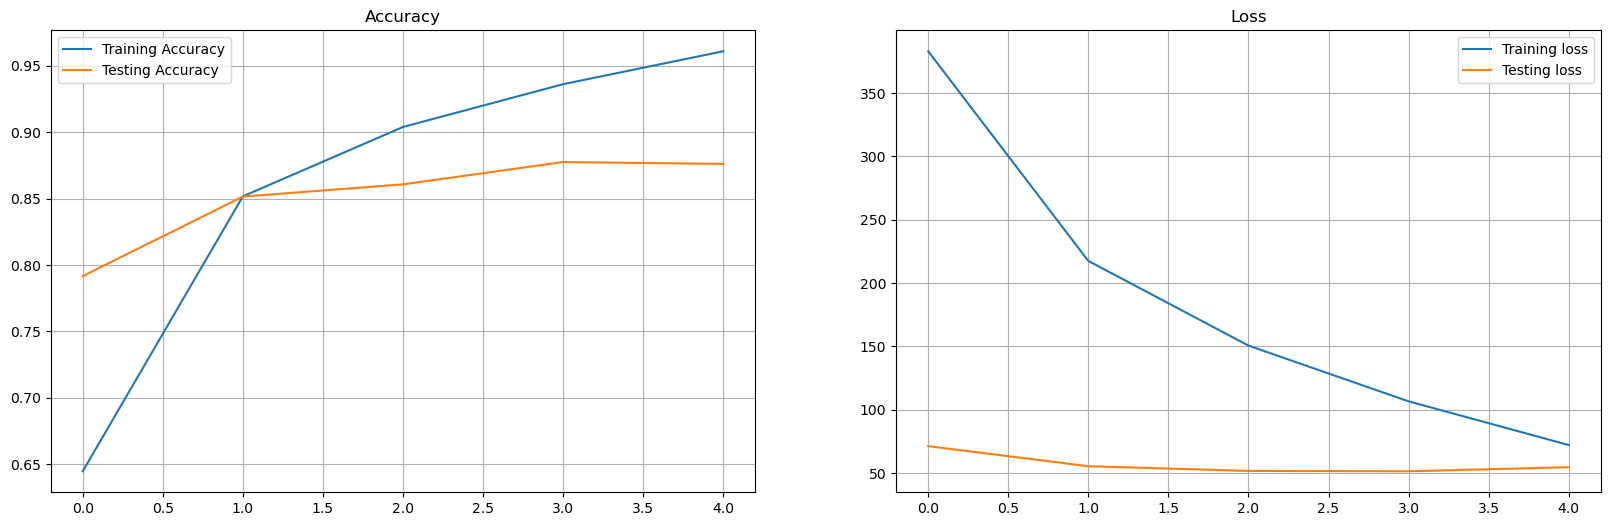

In [57]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_train_acc, label='Training Accuracy')
plt.plot(epoch_test_acc, label='Testing Accuracy')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_train_loss, label='Training loss')
plt.plot(epoch_test_loss, label='Testing loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()